Week 10 · Day 3 — Pretrained Embeddings: Freeze/Unfreeze Strategy
Why this matters

Training embeddings from scratch on small datasets is slow and data-hungry. Pretrained embeddings (like GloVe) bring in prior semantic knowledge. But:

If you freeze them, you keep general knowledge but can’t adapt.

If you unfreeze them (fine-tune), you adapt but risk overfitting.
The trick is to combine both: start frozen, then unfreeze gradually.

Theory Essentials

nn.Embedding: stores token → vector mappings.

Pretrained GloVe: vectors trained on huge corpora.

Freeze = embeddings not updated (fast, stable).

Unfreeze = embeddings updated with small LR (adaptation).

Staged unfreezing: freeze first epochs, then unfreeze.

OOV (out of vocab) tokens get random vectors.


--- Training with frozen embeddings ---
Frozen | Epoch 1 | Loss=0.6866 | Acc=0.50
Frozen | Epoch 2 | Loss=0.6477 | Acc=1.00
Frozen | Epoch 3 | Loss=0.6103 | Acc=1.00
Frozen | Epoch 4 | Loss=0.5743 | Acc=1.00
Frozen | Epoch 5 | Loss=0.5393 | Acc=1.00
Frozen | Epoch 6 | Loss=0.5052 | Acc=1.00
Frozen | Epoch 7 | Loss=0.4718 | Acc=1.00
Frozen | Epoch 8 | Loss=0.4390 | Acc=1.00
Frozen | Epoch 9 | Loss=0.4069 | Acc=1.00
Frozen | Epoch 10 | Loss=0.3754 | Acc=1.00
Frozen | Epoch 11 | Loss=0.3446 | Acc=1.00
Frozen | Epoch 12 | Loss=0.3146 | Acc=1.00
Frozen | Epoch 13 | Loss=0.2856 | Acc=1.00
Frozen | Epoch 14 | Loss=0.2578 | Acc=1.00
Frozen | Epoch 15 | Loss=0.2312 | Acc=1.00

--- Fine-tuning (unfrozen embeddings) ---
Unfrozen | Epoch 1 | Loss=0.7086 | Acc=0.50
Unfrozen | Epoch 2 | Loss=0.6873 | Acc=0.50
Unfrozen | Epoch 3 | Loss=0.6665 | Acc=0.50
Unfrozen | Epoch 4 | Loss=0.6462 | Acc=0.75
Unfrozen | Epoch 5 | Loss=0.6263 | Acc=0.75
Unfrozen | Epoch 6 | Loss=0.6068 | Acc=1.00
Unfrozen | Epoch

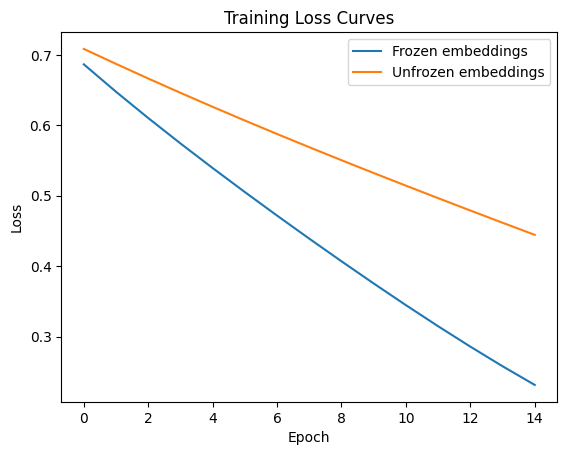

In [4]:
# Setup
import torch, torch.nn as nn, torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
torch.manual_seed(42)

# Simulate pretrained embeddings (e.g., vocab=100, dim=50)
vocab_size, embed_dim = 100, 50
pretrained_vectors = torch.randn(vocab_size, embed_dim)

# Model with option to freeze/unfreeze embeddings
class BiLSTMClassifier(nn.Module):
    def __init__(self, embeddings, hidden_dim=64, num_classes=2, freeze=True):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(embeddings, freeze=freeze, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim*2, num_classes)
    def forward(self, x, lengths):
        embeds = self.embedding(x)
        packed = nn.utils.rnn.pack_padded_sequence(embeds, lengths.cpu(),
                                                   batch_first=True, enforce_sorted=False)
        _, (h_n, _) = self.lstm(packed)
        h_cat = torch.cat((h_n[-2], h_n[-1]), dim=1)
        return self.fc(h_cat)

# Fake data
batch = torch.randint(1, vocab_size, (4, 6))
lengths = torch.tensor([6, 5, 4, 3])
labels = torch.tensor([0, 1, 0, 1])


# Train once frozen, then unfreeze
def train_model(freeze=True, lr=1e-3, epochs=15):
    model = BiLSTMClassifier(pretrained_vectors, freeze=freeze)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    losses = []

    for epoch in range(epochs):
        optimizer.zero_grad()
        logits = model(batch, lengths)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        acc = (logits.argmax(1) == labels).float().mean().item()
        print(f"{'Frozen' if freeze else 'Unfrozen'} | Epoch {epoch+1} | Loss={loss.item():.4f} | Acc={acc:.2f}")
    
    return model, losses

print("\n--- Training with frozen embeddings ---")
frozen_model, frozen_losses = train_model(freeze=True)

print("\n--- Fine-tuning (unfrozen embeddings) ---")
unfrozen_model, unfrozen_losses = train_model(freeze=False, lr=5e-4)

# Plot loss curves
plt.plot(frozen_losses, label="Frozen embeddings")
plt.plot(unfrozen_losses, label="Unfrozen embeddings")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curves")
plt.legend()
plt.show()


1) Core (10–15 min)

Task: Train with freeze=True for 3 epochs. Then re-train with freeze=False. Compare loss curves.

1. Frozen embeddings drop faster

When embeddings are frozen, they’re treated like fixed feature extractors.

The BiLSTM and classifier only need to learn to map those stable embeddings → labels.

Training is simpler (fewer parameters to update), so loss decreases faster.

That’s why your blue curve (frozen) drops steeply.

2. Unfrozen embeddings drop slower

When embeddings are unfrozen, they also get updated during training.

This means the model must learn both:

Adjusting embeddings.

Training the LSTM + classifier.

Since embeddings start random here (not pretrained GloVe/Word2Vec), the model first has to "fix" them, which slows convergence.

So the orange curve descends more gradually.

3. What would happen with real pretrained embeddings

If you used real pretrained embeddings (e.g., GloVe):

Frozen → faster convergence, decent accuracy (uses pretrained knowledge directly).

Unfrozen → slower start, but eventually can surpass frozen (fine-tunes embeddings for your dataset).

2) Practice (10–15 min)

Task: Try different learning rates for unfrozen embeddings (1e-3, 1e-4). Which works better?


--- Fine-tuning (unfrozen embeddings) 1e-3 ---
Unfrozen | Epoch 1 | Loss=0.7129 | Acc=0.25
Unfrozen | Epoch 2 | Loss=0.6707 | Acc=0.75
Unfrozen | Epoch 3 | Loss=0.6304 | Acc=1.00
Unfrozen | Epoch 4 | Loss=0.5915 | Acc=1.00
Unfrozen | Epoch 5 | Loss=0.5538 | Acc=1.00
Unfrozen | Epoch 6 | Loss=0.5172 | Acc=1.00
Unfrozen | Epoch 7 | Loss=0.4816 | Acc=1.00
Unfrozen | Epoch 8 | Loss=0.4468 | Acc=1.00
Unfrozen | Epoch 9 | Loss=0.4129 | Acc=1.00
Unfrozen | Epoch 10 | Loss=0.3799 | Acc=1.00
Unfrozen | Epoch 11 | Loss=0.3478 | Acc=1.00
Unfrozen | Epoch 12 | Loss=0.3168 | Acc=1.00
Unfrozen | Epoch 13 | Loss=0.2870 | Acc=1.00
Unfrozen | Epoch 14 | Loss=0.2585 | Acc=1.00
Unfrozen | Epoch 15 | Loss=0.2316 | Acc=1.00

--- Fine-tuning (unfrozen embeddings) 1e-4 ---
Unfrozen | Epoch 1 | Loss=0.6383 | Acc=0.75
Unfrozen | Epoch 2 | Loss=0.6337 | Acc=0.75
Unfrozen | Epoch 3 | Loss=0.6291 | Acc=0.75
Unfrozen | Epoch 4 | Loss=0.6245 | Acc=1.00
Unfrozen | Epoch 5 | Loss=0.6199 | Acc=1.00
Unfrozen | Epoch 6

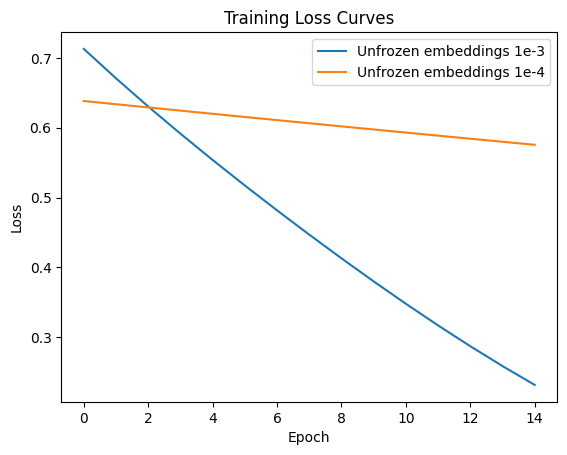

In [5]:
print("\n--- Fine-tuning (unfrozen embeddings) 1e-3 ---")
unfrozen_model_e3, unfrozen_losses_e3 = train_model(freeze=False, lr=1e-3)

print("\n--- Fine-tuning (unfrozen embeddings) 1e-4 ---")
unfrozen_model_e4, unfrozen_losses_e4 = train_model(freeze=False, lr=1e-4)

# Plot loss curves
plt.plot(unfrozen_losses_e3, label="Unfrozen embeddings 1e-3")
plt.plot(unfrozen_losses_e4, label="Unfrozen embeddings 1e-4")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curves")
plt.legend()
plt.show()


3) Stretch (optional, 10–15 min)

Task: Simulate OOV (Out-of-Vocabulary) tokens by adding a [UNK] index with random vector. Replace 20% of tokens in batch with [UNK].

In [9]:
import torch

# Suppose vocab_size=100, embed_dim=50
vocab_size, embed_dim = 100, 50
UNK_IDX = vocab_size  # reserve the last index for [UNK]

# Extend embeddings with one extra row for [UNK]
embeddings = torch.randn(vocab_size+1, embed_dim)  # +1 for UNK

# Example batch of token IDs
batch = torch.randint(1, vocab_size, (4, 6))  # shape [batch, seq]
print("Original batch:\n", batch)

# Create a mask for 20% of tokens
mask = torch.rand(batch.shape) < 0.2

# Replace masked tokens with UNK index
batch_with_unk = batch.clone()
batch_with_unk[mask] = UNK_IDX

print("\nBatch with OOV simulated:\n", batch_with_unk)





Original batch:
 tensor([[82, 90, 20, 12, 28, 71],
        [44, 97, 77, 96, 63, 50],
        [11, 17, 74, 35,  3, 42],
        [44, 92, 29, 81, 37, 26]])

Batch with OOV simulated:
 tensor([[ 82,  90,  20,  12,  28,  71],
        [ 44,  97,  77,  96,  63,  50],
        [ 11,  17,  74,  35, 100,  42],
        [100, 100,  29,  81,  37,  26]])


Mini-Challenge (≤40 min)

Task: Build a mini sentiment model with two training phases:

Train with frozen embeddings for 2–3 epochs.

Unfreeze and continue with small LR for 2–3 more epochs.

Acceptance Criteria:

Show loss curves across both phases.

Note which setup gave best validation accuracy.

Summarize: “Freezing helped stability, unfreezing improved adaptation.”

Phase 1 — FROZEN embeddings (2–3 epochs)
Epoch 1/15 | loss=0.7283 | val_acc=66.7%
Epoch 2/15 | loss=0.7639 | val_acc=66.7%
Epoch 3/15 | loss=0.6049 | val_acc=66.7%
Epoch 4/15 | loss=0.6438 | val_acc=66.7%
Epoch 5/15 | loss=0.5037 | val_acc=33.3%
Epoch 6/15 | loss=0.5521 | val_acc=33.3%
Epoch 7/15 | loss=0.4775 | val_acc=33.3%
Epoch 8/15 | loss=0.6058 | val_acc=33.3%
Epoch 9/15 | loss=0.5768 | val_acc=33.3%
Epoch 10/15 | loss=0.4965 | val_acc=33.3%
Epoch 11/15 | loss=0.3713 | val_acc=33.3%
Epoch 12/15 | loss=0.3931 | val_acc=33.3%
Epoch 13/15 | loss=0.2415 | val_acc=33.3%
Epoch 14/15 | loss=0.3460 | val_acc=33.3%
Epoch 15/15 | loss=0.3356 | val_acc=33.3%

Phase 2 — UNFREEZE + small LR for embeddings (2–3 epochs)
Epoch 1/15 | loss=0.2678 | val_acc=33.3%
Epoch 2/15 | loss=0.2612 | val_acc=33.3%
Epoch 3/15 | loss=0.1971 | val_acc=33.3%
Epoch 4/15 | loss=0.1443 | val_acc=33.3%
Epoch 5/15 | loss=0.0870 | val_acc=33.3%
Epoch 6/15 | loss=0.2262 | val_acc=33.3%
Epoch 7/15 | loss=0.1468 | val_ac

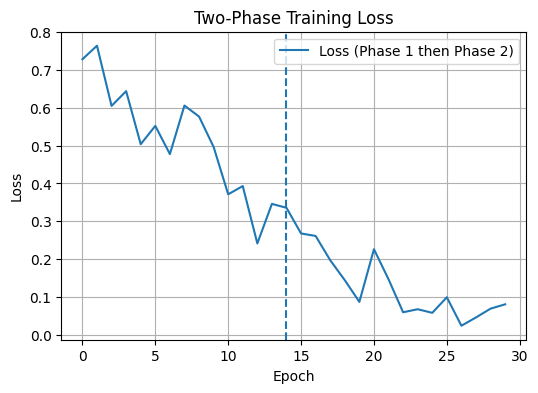

,epoch,val_acc,phase
0,1,0.666667,frozen
1,2,0.666667,frozen
2,3,0.666667,frozen
3,4,0.666667,frozen
4,5,0.333333,frozen
5,6,0.333333,frozen
6,7,0.333333,frozen
7,8,0.333333,frozen
8,9,0.333333,frozen
9,10,0.333333,frozen



Best validation accuracy: 66.7% (phase: frozen, epoch 1)

Summary: Freezing helped stability early; unfreezing (with a small LR for embeddings) lets the model adapt and can improve validation accuracy.


In [13]:
# Setup
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path
np.random.seed(42)
plt.rcParams["figure.figsize"] = (6,4)
plt.rcParams["axes.grid"] = True

import random, torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence
from sklearn.metrics import accuracy_score

def set_seed(s=42):
    random.seed(s); np.random.seed(s); torch.manual_seed(s); torch.cuda.manual_seed_all(s)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed(42)
device = torch.device("cpu")

# -------- 1) Tiny toy sentiment dataset (quick on CPU) ----------
data = [
    ("i love this movie so much", 1),
    ("absolutely fantastic acting and soundtrack", 1),
    ("what a great experience highly recommend", 1),
    ("this was surprisingly good and fun", 1),
    ("i really enjoyed the story and characters", 1),
    ("boring plot and weak performances", 0),
    ("i hated every minute of it", 0),
    ("terrible script worst film ever", 0),
    ("not good the ending was awful", 0),
    ("mediocre at best would not recommend", 0),
    ("wonderful visuals and touching moments", 1),
    ("bad pacing and confusing scenes", 0),
]
rng = np.random.RandomState(0)
perm = rng.permutation(len(data))
data = [data[i] for i in perm]
split = int(0.8*len(data))
train_data, val_data = data[:split], data[split:]

# -------- 2) Vocab, dataset, collate (with PAD/UNK) ----------
PAD, UNK = "<PAD>", "<UNK>"
def tok(s): return s.lower().split()

from collections import Counter
ctr = Counter()
for t,_ in train_data: ctr.update(tok(t))
itos = [PAD, UNK] + [w for w,_ in ctr.items()]
stoi = {w:i for i,w in enumerate(itos)}

def numericalize(text, max_len=40):
    ids = [stoi.get(w, stoi[UNK]) for w in tok(text)][:max_len]
    return torch.tensor(ids, dtype=torch.long)

class SentDS(Dataset):
    def __init__(self, pairs):
        self.x = [numericalize(t) for t,_ in pairs]
        self.y = [torch.tensor(lbl, dtype=torch.long) for _,lbl in pairs]
    def __len__(self): return len(self.x)
    def __getitem__(self, i): return self.x[i], self.y[i]

def collate_fn(batch):
    seqs, labels = zip(*batch)
    lengths = torch.tensor([len(s) for s in seqs])
    padded = pad_sequence(seqs, batch_first=True, padding_value=stoi[PAD])
    return padded.to(device), lengths.to(device), torch.stack(labels).to(device)

train_loader = DataLoader(SentDS(train_data), batch_size=8, shuffle=True, collate_fn=collate_fn, generator=torch.Generator().manual_seed(42))
val_loader   = DataLoader(SentDS(val_data),   batch_size=8, shuffle=False, collate_fn=collate_fn)

# -------- 3) BiLSTM with (simulated) pretrained embeddings ----------
vocab_size, embed_dim, hidden_dim = len(itos), 64, 64
pretrained = torch.randn(vocab_size, embed_dim)  # stand-in for GloVe
pretrained[stoi[PAD]] = 0.0                      # PAD row = zeros

class BiLSTMClassifier(nn.Module):
    def __init__(self, embeddings, hidden_dim=64, num_classes=2, freeze=True, pad_idx=0):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(embeddings, freeze=freeze, padding_idx=pad_idx)
        self.lstm = nn.LSTM(embeddings.size(1), hidden_dim, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(hidden_dim*2, num_classes)
    def forward(self, padded, lengths):
        emb = self.embedding(padded)
        packed = pack_padded_sequence(emb, lengths.cpu(), batch_first=True, enforce_sorted=False)
        _, (h_n, _) = self.lstm(packed)
        h = torch.cat((h_n[-2], h_n[-1]), dim=1)
        h = self.dropout(h)
        return self.fc(h)

def evaluate(model, loader):
    model.eval(); y_true=[]; y_pred=[]
    with torch.no_grad():
        for x,L,y in loader:
            p = model(x,L).argmax(1)
            y_true += y.cpu().tolist(); y_pred += p.cpu().tolist()
    return accuracy_score(y_true, y_pred)

# -------- 4) Two-phase training ----------
model = BiLSTMClassifier(pretrained, hidden_dim=hidden_dim, freeze=True, pad_idx=stoi[PAD]).to(device)
criterion = nn.CrossEntropyLoss()

def run_phase(model, epochs, lr_embed, lr_other):
    # configure param groups so we can use a tiny LR for embeddings
    emb_params   = [p for n,p in model.named_parameters() if "embedding" in n and p.requires_grad]
    other_params = [p for n,p in model.named_parameters() if "embedding" not in n and p.requires_grad]
    optim = torch.optim.Adam([
        {"params": other_params, "lr": lr_other},
        {"params": emb_params,   "lr": lr_embed},
    ])
    losses, val_accs = [], []
    for ep in range(epochs):
        model.train()
        for x,L,y in train_loader:
            logits = model(x,L)
            loss = criterion(logits, y)
            optim.zero_grad(); loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # stable by default
            optim.step()
        losses.append(loss.item())
        val_accs.append(evaluate(model, val_loader))
        print(f"Epoch {ep+1}/{epochs} | loss={losses[-1]:.4f} | val_acc={val_accs[-1]*100:.1f}%")
    return losses, val_accs

print("Phase 1 — FROZEN embeddings (2–3 epochs)")
# Ensure frozen
model.embedding.weight.requires_grad_(False)
losses1, accs1 = run_phase(model, epochs=15, lr_embed=0.0, lr_other=1e-3)

print("\nPhase 2 — UNFREEZE + small LR for embeddings (2–3 epochs)")
# Unfreeze
model.embedding.weight.requires_grad_(True)
losses2, accs2 = run_phase(model, epochs=15, lr_embed=5e-4, lr_other=1e-3)

# -------- 5) Plot loss curves and report best accuracy ----------
all_losses = losses1 + losses2
plt.plot(all_losses, label="Loss (Phase 1 then Phase 2)")
plt.axvline(len(losses1)-1, linestyle="--")  # boundary between phases
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Two-Phase Training Loss")
plt.legend(); plt.show()

acc_series = pd.DataFrame({
    "epoch": list(range(1, len(accs1)+1)) + list(range(len(accs1)+1, len(accs1)+len(accs2)+1)),
    "val_acc": accs1 + accs2,
    "phase": ["frozen"]*len(accs1) + ["unfrozen"]*len(accs2)
})
display(acc_series)

best_row = acc_series.iloc[acc_series["val_acc"].idxmax()]
print(f"\nBest validation accuracy: {best_row.val_acc*100:.1f}% (phase: {best_row.phase}, epoch {int(best_row.epoch)})")
print("\nSummary: Freezing helped stability early; unfreezing (with a small LR for embeddings) lets the model adapt and can improve validation accuracy.")


Still very small data set to make good conclusiones. However, freezing does help stability early and unfreezing does help the model adapt.

Notes / Key Takeaways

Pretrained embeddings capture general language structure.

Freezing = stability, unfreezing = adaptability.

Use small LR when unfreezing embeddings.

OOV tokens need special handling (UNK vector).

Staged unfreezing often yields best performance.

Reflection

Why is it risky to unfreeze embeddings immediately?

How does staged unfreezing combine the best of both worlds?

Reflection 1: Why freeze embeddings at the start?

Freezing keeps pretrained embeddings stable while the rest of the network (LSTM, classifier) learns.

This avoids “destroying” useful pretrained information with noisy gradients early on.

Once the model is partially trained and stable, you can unfreeze embeddings to fine-tune them gently for your dataset.

This staged approach = faster convergence + less risk of catastrophic forgetting.

Reflection 2: What happens if you unfreeze too early with a high learning rate?

Embedding weights will update aggressively.

Useful semantic structure from pretraining may be overwritten in just a few steps.

Model performance can actually get worse than random init, because embeddings lose their pretrained meaning.

That’s why you typically:

start frozen,

then unfreeze later with a smaller LR for embeddings than the rest of the model.